Import libraries

In [1]:
import os

import pandas as pd

import numpy as np

from scipy import stats
import scipy.stats as sc
from scipy.cluster.hierarchy import linkage, leaves_list

import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Import data

In [2]:
dataFolderName = '../data_luc/video/'

listVideoName =   ['x264-1908-bridgefar-wasm/x264-results1.csv', 
                   'x264-1908-ice-wasm/x264-results1.csv',
                   'x264-1908-flower-wasm/x264-results1.csv', 
                   'x264-1908-caire-wasm/x264-results1.csv',
                   'x264-0208-sintel-calda-wasm/x264-results1.csv', 
                   'x264-1908-footballcif-wasm/x264-results1.csv',
                   'x264-0308-crowd_run-wasm/x264-results1.csv', 
                   'x264-0608-blue-wasm/x264-results1.csv',
                   'x264-0608-people-wasm/x264-results1.csv', 
                   'x264-1908-sunflowers-wasm/x264-results1.csv',
                   'x264-0408-deadline-wasm/x264-results1.csv', 
                   'x264-2108-bridgeclose-wasm/x264-results1.csv',
                   'x264-1908-husky-wasm/x264-results1.csv', 
                   'x264-1908-tennis-wasm/x264-results1.csv',
                   'x264-1908-riverbed-wasm/x264-results1.csv', 
                   'x264-0608-park-wasm/x264-results1.csv',
                   'x264-0508-soccer-wasm/x264-results1.csv']

# creation of the list of videos (for each video: x264 configurations + measurements)
listVideo = []

for vn in listVideoName:
    listVideo.append(pd.read_csv(open(dataFolderName+vn,"r")))
    
nbVideos = len(listVideo)

# test
print("There are " + str(len(listVideo)) + " videos")
assert (len(listVideoName) == len(listVideo))


#print a csv
listVideo[7].drop(['no_8x8dct', 'no_deblock', 'no_mixed_refs', 'no_weightb', 'size', 'usertime', 'systemtime', 'H264', 'no_asm', 'configurationID'], axis=1)[:10]

There are 17 videos


,no_cabac,no_fast_pskip,no_mbtree,rc_lookahead,ref,elapsedtime
0,False,True,False,20,9,5.074625
1,True,True,False,40,9,5.902625
2,False,False,True,40,1,2.908125
3,True,True,True,40,9,5.027500
4,False,False,False,60,5,4.329125
5,True,True,False,60,5,4.710125
6,False,False,False,60,1,3.624125
7,True,True,False,60,1,3.680875
8,False,True,False,60,1,3.512125
9,False,True,False,60,9,6.309250


## 2) Model shifting implementation

In [11]:
nbVideos = len(listVideo)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))

random_state = np.random.randint(0,1000)

res_model_shift = pd.DataFrame({'id_video' : range(nbVideos)})


nbConfig = [16,32,64,128,256,320,448,640,960]

for conf in nbConfig:

    pct_test = conf/listVideo[0].size

    mat_mape_ms = np.ones(nbVideos*nbVideos).reshape(nbVideos, nbVideos)

    for i in range(nbVideos):
        for j in range(nbVideos):

            source = listVideo[i] #i
            X_src = source[['no_8x8dct','no_asm', 'no_cabac','no_deblock','no_fast_pskip',
                'no_mbtree','no_mixed_refs','no_weightb','rc_lookahead','ref']] 
            y_src = np.array(source['elapsedtime'], 
                             dtype=float)

            X_src_train, X_src_test, y_src_train, y_src_test = train_test_split(X_src, 
                                                                                y_src, 
                                                                                test_size=pct_test, 
                                                                                random_state=random_state)

            target = listVideo[j] #j
            X_tgt = target[['no_8x8dct','no_asm', 'no_cabac','no_deblock','no_fast_pskip',
                'no_mbtree','no_mixed_refs','no_weightb','rc_lookahead','ref']] 
            y_tgt = np.array(target['elapsedtime'], 
                             dtype=float)

            X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(X_tgt, 
                                                                                y_tgt, 
                                                                                test_size=pct_test, 
                                                                                random_state=random_state)

            coef, intercept, r_value, _ , std_err = stats.linregress(y_src_train, y_tgt_train)

            clf = RandomForestRegressor()
            clf.fit(X_src_train, y_src_train)

            y_src_pred_test = clf.predict(X_src_test)

            y_tgt_pred_test = intercept + coef*y_src_pred_test

            mat_mape_ms[i][j] = min(mape(y_tgt_test, y_tgt_pred_test),1)

    mean_video = []
    for k in range(len(mat_mape_ms)):
        mean_video.append(np.mean(mat_mape_ms[:,k]))

    res_model_shift[str(conf)] = mean_video

In [12]:
res = res_model_shift.set_index('id_video')
res.to_csv("../data_luc/expe/res_model_shift_nb_conf_training.csv")
res

,16,32,64,128,256,320,448,640,960
id_video,,,,,,,,,
0,0.164742,0.103808,0.091867,0.093092,0.110743,0.113365,0.112688,0.115374,0.116946
1,0.094017,0.071347,0.054987,0.069972,0.076319,0.075635,0.081441,0.077607,0.076335
2,0.168759,0.143338,0.106348,0.115942,0.127902,0.126186,0.136439,0.124284,0.110174
3,0.069577,0.075137,0.088887,0.089768,0.109903,0.105136,0.104891,0.106385,0.098982
4,0.047532,0.044724,0.045653,0.049829,0.056363,0.055444,0.059760,0.058845,0.056857
5,0.077984,0.063139,0.053670,0.065810,0.075493,0.072901,0.080606,0.078417,0.072608
6,0.059392,0.055755,0.057941,0.063051,0.073736,0.073806,0.077638,0.077018,0.072452
7,0.049157,0.043165,0.041667,0.053128,0.066563,0.066780,0.074948,0.072910,0.068294
8,0.050130,0.063591,0.052422,0.061119,0.072570,0.072558,0.078708,0.077977,0.072778


In [4]:
def plot_dendogram(corr, img_name, method, ticks, div=False, title=''):

    df = pd.DataFrame(corr)
    
    sns.clustermap(df, cmap="vlag", method=method,
               linewidths=.75, figsize=(13, 13), cbar_kws={"ticks":ticks})
    plt.title(title)
    plt.savefig(img_name)
    plt.show()

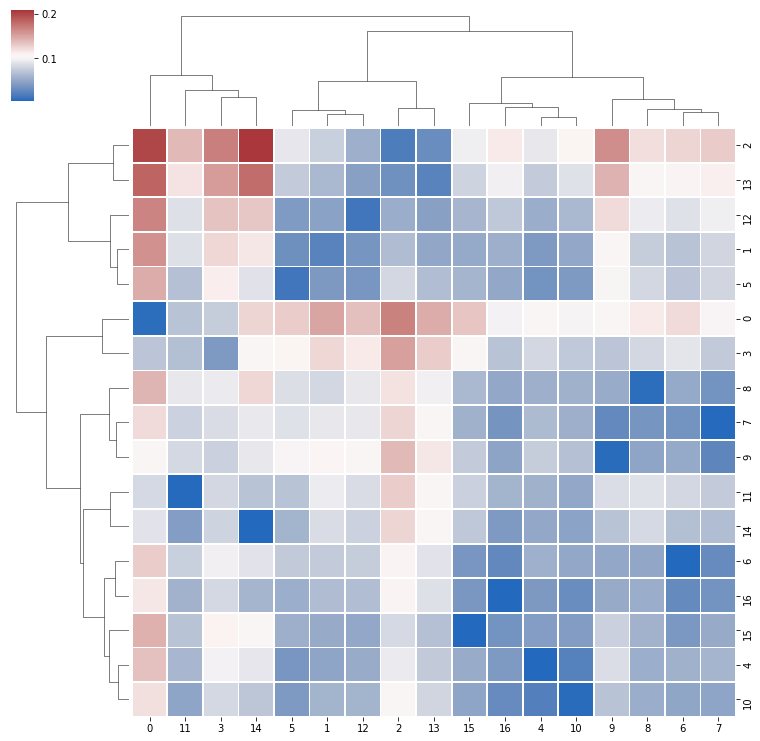

In [5]:
method = 'ward'
plot_dendogram(mat_mape_ms, 
               "mape_score_ms.pdf",
               method, 
               [k/10 for k in range(11)],
               div=True)